In [1]:
import matplotlib.pyplot as plt
import torch, torchvision
from torch import nn
from torchvision import transforms
from torchinfo import summary
from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Getting data

In [3]:
data_20_percent_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
    destination='pizza_steak_sushi_20_percent'
)
data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [4]:
train_dir = data_20_percent_path / 'train'
test_dir = data_20_percent_path / 'test'

## EffNetB2 model

In [5]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()
effnetb2 = torchvision.models.efficientnet_b2(
    weights=effnetb2_weights
)
for param in effnetb2.parameters():
    param.requires_grad = False

In [6]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [7]:
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(1408, 3)
).to(device)

In [8]:
def create_effnetb2_model(
    num_classes: int = 3,
    seed: int = 42
):
    """
    Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of clases in the 
            classifier head. Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.
    
    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False
    
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )
    
    return model, transforms

In [9]:
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3,
    seed=42
)

In [10]:
from torchinfo import summary

summary(
    model=effnetb2,
    input_size=(1, 3, 224, 224),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [11]:
from going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names \
    = data_setup.create_dataloaders(
        train_dir=train_dir,
        test_dir=test_dir,
        transform=effnetb2_transforms,
        batch_size=32
    )

In [12]:
from going_modular import engine

optimizer = torch.optim.Adam(
    params=effnetb2.parameters(),
    lr=1e-3
)
loss_fn = nn.CrossEntropyLoss()
set_seeds()
effetb2_results = engine.train(
    model=effnetb2,
    train_dataloader=train_dataloader_effnetb2,
    test_dataloader=test_dataloader_effnetb2,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9751 | train_acc: 0.5979 | test_loss: 0.7344 | test_acc: 0.9347
Epoch: 2 | train_loss: 0.7311 | train_acc: 0.8208 | test_loss: 0.5516 | test_acc: 0.9437
Epoch: 3 | train_loss: 0.5399 | train_acc: 0.8979 | test_loss: 0.4965 | test_acc: 0.9534
Epoch: 4 | train_loss: 0.4656 | train_acc: 0.8917 | test_loss: 0.4127 | test_acc: 0.9534
Epoch: 5 | train_loss: 0.4231 | train_acc: 0.8875 | test_loss: 0.3770 | test_acc: 0.9597
Epoch: 6 | train_loss: 0.3985 | train_acc: 0.8917 | test_loss: 0.3311 | test_acc: 0.9625
Epoch: 7 | train_loss: 0.3696 | train_acc: 0.8875 | test_loss: 0.3298 | test_acc: 0.9358
Epoch: 8 | train_loss: 0.3793 | train_acc: 0.8812 | test_loss: 0.2992 | test_acc: 0.9750
Epoch: 9 | train_loss: 0.3127 | train_acc: 0.9167 | test_loss: 0.2866 | test_acc: 0.9597
Epoch: 10 | train_loss: 0.2791 | train_acc: 0.9375 | test_loss: 0.2724 | test_acc: 0.9472


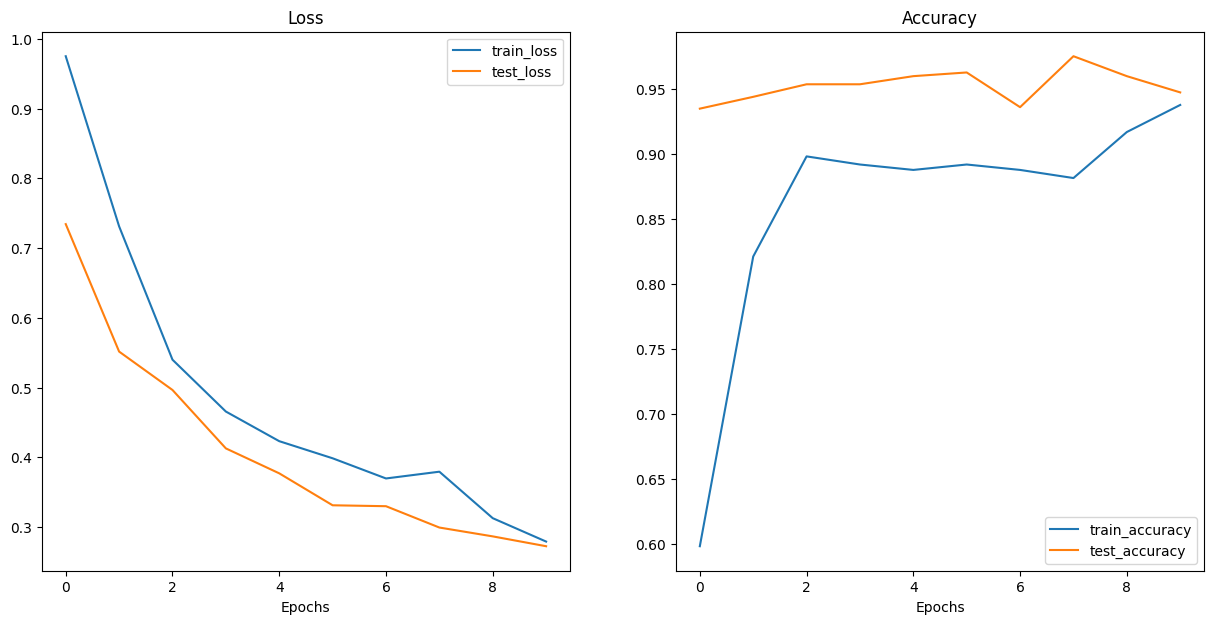

In [13]:
from helper_functions import plot_loss_curves
plot_loss_curves(effetb2_results)

In [14]:
from going_modular import utils

utils.save_model(
    model=effnetb2,
    target_dir='models',
    model_name='09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth'
)

[INFO] Saving model to:  models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [15]:
from pathlib import Path

pretrained_effnetb2_model_size = Path(
    'models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth'
).stat().st_size // (1024**2)
print(pretrained_effnetb2_model_size, 'MB')

29 MB


In [16]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [17]:
effnetb2_stats = {
    'test_loss': effetb2_results['test_loss'][-1],
    'test_acc': effetb2_results['test_acc'][-1],
    'number_of_parameters': effnetb2_total_params,
    'model_size (MB)': pretrained_effnetb2_model_size
}
effnetb2_stats

{'test_loss': 0.27243826985359193,
 'test_acc': 0.947159090909091,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## ViT model

In [18]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [19]:
def create_vit_model(
    num_classes: int = 3,
    seed: int = 42
):
    """
    Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes.
            Defaults to 3.
        seed (int, optional): random seed value for output layer.
            Defaults to 42.
    
    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    for param in model.parameters():
        param.requires_grad = False
    
    torch.manual_seed(seed)
    model.heads = nn.Sequential(
        nn.Linear(in_features=768, out_features=num_classes)
    )

    return model, transforms

In [20]:
vit, vit_transforms = create_vit_model(num_classes=3, seed=42)

In [21]:
from torchinfo import summary

summary(
    model=vit,
    input_size=(1, 3, 224, 224),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [22]:
from going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names \
    = data_setup.create_dataloaders(
        train_dir=train_dir,
        test_dir=test_dir,
        transform=vit_transforms,
        batch_size=32
    )

In [23]:
from going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
vit_results = engine.train(
    model=vit,
    train_dataloader=train_dataloader_vit,
    test_dataloader=test_dataloader_vit,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2614 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.2197 | train_acc: 0.9437 | test_loss: 0.1492 | test_acc: 0.9688
Epoch: 3 | train_loss: 0.1534 | train_acc: 0.9583 | test_loss: 0.1125 | test_acc: 0.9750
Epoch: 4 | train_loss: 0.1304 | train_acc: 0.9604 | test_loss: 0.0961 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1079 | train_acc: 0.9688 | test_loss: 0.0821 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.0981 | train_acc: 0.9750 | test_loss: 0.0776 | test_acc: 0.9812
Epoch: 7 | train_loss: 0.0908 | train_acc: 0.9812 | test_loss: 0.0727 | test_acc: 0.9756
Epoch: 8 | train_loss: 0.0729 | train_acc: 0.9854 | test_loss: 0.0645 | test_acc: 0.9875
Epoch: 9 | train_loss: 0.0647 | train_acc: 0.9854 | test_loss: 0.0606 | test_acc: 0.9750
Epoch: 10 | train_loss: 0.0558 | train_acc: 0.9854 | test_loss: 0.0613 | test_acc: 0.9750


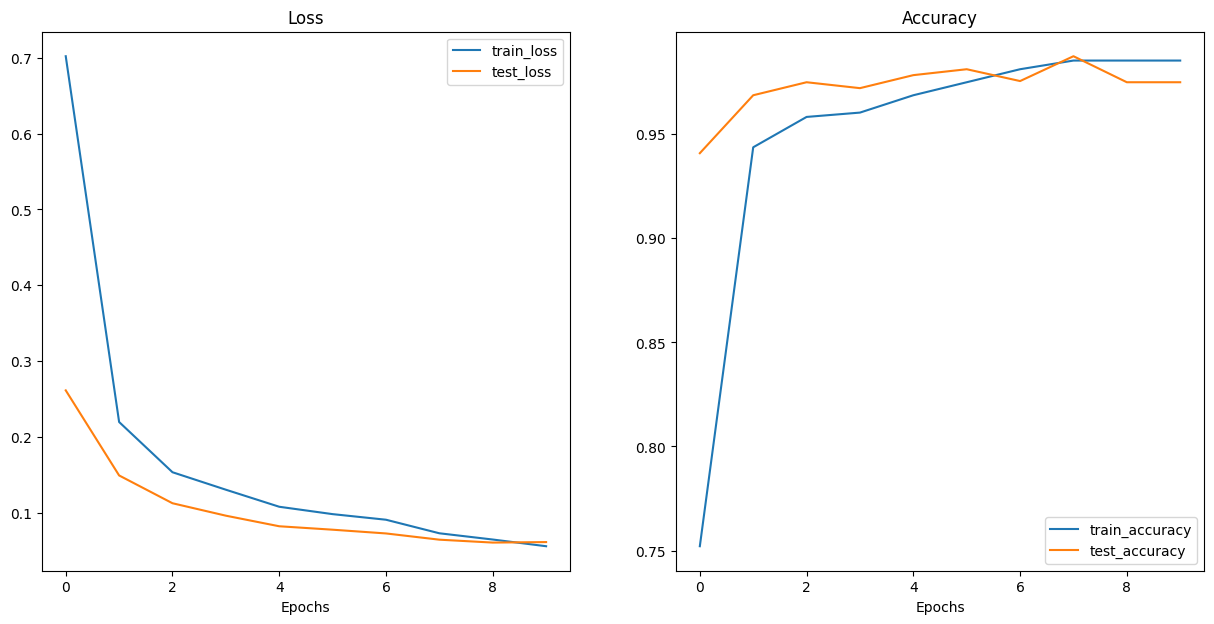

In [24]:
from helper_functions import plot_loss_curves
plot_loss_curves(vit_results)

In [25]:
from going_modular import utils

utils.save_model(
    model=vit,
    target_dir='models',
    model_name='09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth'
)

[INFO] Saving model to:  models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [27]:
from pathlib import Path

pretrained_vit_model_size = Path(
    'models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth'
).stat().st_size // (1024**2)
print(pretrained_vit_model_size, 'MB')

327 MB


In [28]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [30]:
vit_stats = {
    'test_loss': vit_results['test_loss'][-1],
    'test_acc': vit_results['test_acc'][-1],
    'number_of_parameters': vit_total_params,
    'model_size (MB)': pretrained_vit_model_size
}
vit_stats

{'test_loss': 0.06129767447710037,
 'test_acc': 0.975,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## Making predictions and timing our models

In [31]:
from pathlib import Path

print(
    '[INFO] Finding all filepaths ending with \'.jpg\' in directory:',
    test_dir
)
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1166047.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2315011.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3757027.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/289822.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2365038.jpg')]

In [32]:
import pathlib, torch
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(
    paths: List[pathlib.Path],
    model: torch.nn.Module,
    transform: torchvision.transforms,
    class_names: List[str],
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
) -> List[Dict]:
    pred_list = []

    for path in tqdm(paths):
        pred_dict = {}
        pred_dict['image_path'] = path
        class_name = path.parent.stem
        pred_dict['class_name'] = class_name

        start_time = timer()

        img = Image.open(path)
        transformed_image = transform(img).unsqueeze(0).to(device)
        model.to(device)
        model.eval()
        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]
            pred_dict['pred_prob'] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict['pred_class'] = pred_class

            end_time = timer()
            pred_dict['time_for_pred'] = round(end_time-start_time, 4)
        pred_dict['correct'] = class_name==pred_class
        pred_list.append(pred_dict)
    return pred_list

In [33]:
effnetb2_test_pred_dicts = pred_and_store(
    paths=test_data_paths,
    model=effnetb2,
    transform=effnetb2_transforms,
    class_names=class_names,
    device='cpu'
)

  0%|          | 0/150 [00:00<?, ?it/s]

In [34]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1166047.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.867,
  'pred_class': 'steak',
  'time_for_pred': 0.1241,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2315011.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.8445,
  'pred_class': 'steak',
  'time_for_pred': 0.0466,
  'correct': True}]

In [35]:
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.8670,steak,0.1241,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.8445,steak,0.0466,True
2,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.4411,sushi,0.0444,False
3,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9928,steak,0.0387,True
4,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.8027,steak,0.0393,True


In [36]:
effnetb2_test_pred_df.correct.value_counts()

True     142
False      8
Name: correct, dtype: int64

In [37]:
effnetb2_average_time_per_pred = round(
    effnetb2_test_pred_df.time_for_pred.mean(),
    4
)
print(effnetb2_average_time_per_pred, 'seconds')

0.0403 seconds


In [38]:
effnetb2_stats['time_per_pred_cpu'] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.27243826985359193,
 'test_acc': 0.947159090909091,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.0403}

In [39]:
vit_test_pred_dicts = pred_and_store(
    paths=test_data_paths,
    model=vit,
    transform=vit_transforms,
    class_names=class_names,
    device='cpu'
)

  0%|          | 0/150 [00:00<?, ?it/s]

In [40]:
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1166047.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9969,
  'pred_class': 'steak',
  'time_for_pred': 0.3024,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2315011.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9774,
  'pred_class': 'steak',
  'time_for_pred': 0.153,
  'correct': True}]

In [41]:
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9969,steak,0.3024,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9774,steak,0.1530,True
2,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.4730,steak,0.1339,True
3,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9982,steak,0.1360,True
4,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9810,steak,0.1338,True


In [42]:
vit_test_pred_df.correct.value_counts()

True     146
False      4
Name: correct, dtype: int64

In [43]:
vit_average_time_per_pred = round(
    vit_test_pred_df.time_for_pred.mean(),
    4
)
print(vit_average_time_per_pred, 'seconds')

0.1333 seconds


In [44]:
vit_stats['time_per_pred_cpu'] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06129767447710037,
 'test_acc': 0.975,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.1333}

## Comparing the models

In [46]:
df = pd.DataFrame([effnetb2_stats, vit_stats])
df['model'] = ['EffNetB2', 'ViT']
df['test_acc'] = round(df['test_acc']*100, 2)
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.272438,94.72,7705221,29,0.0403,EffNetB2
1,0.061298,97.50,85800963,327,0.1333,ViT


In [47]:
pd.DataFrame(
    data=(df.set_index('model').loc['ViT'] / df.set_index('model').loc['EffNetB2']),
    columns=['ViT to EffNetB2 ratios']
).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.224997,1.02935,11.135432,11.275862,3.307692


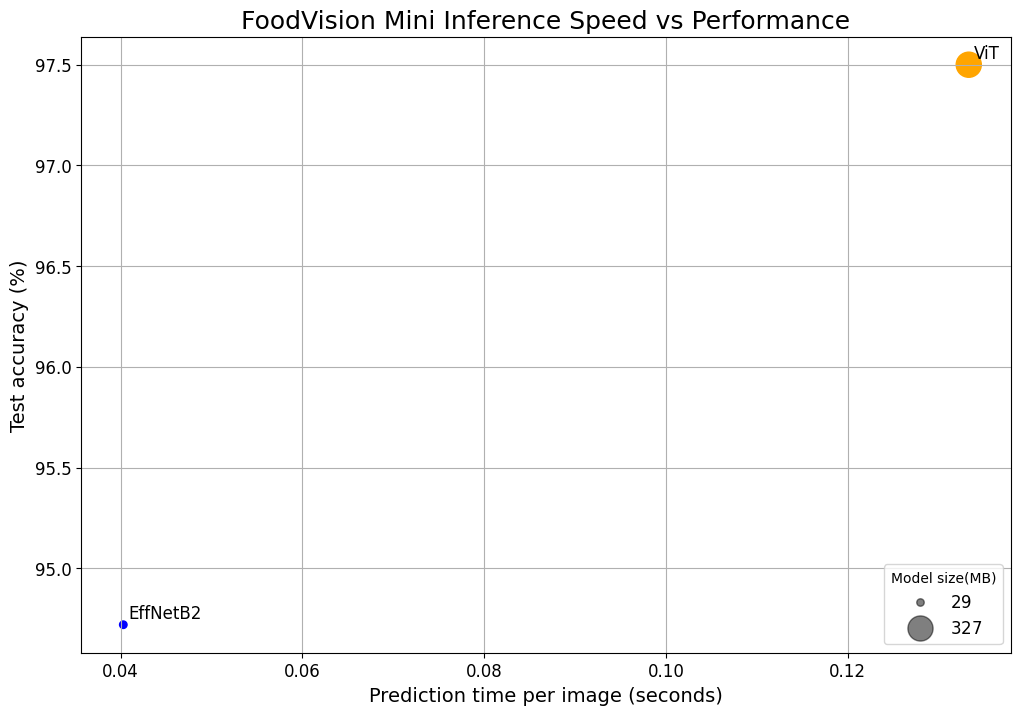

In [49]:
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(
    data=df,
    x='time_per_pred_cpu',
    y='test_acc',
    c=['blue', 'orange'],
    s='model_size (MB)'
)

ax.set_title('FoodVision Mini Inference Speed vs Performance', fontsize=18)
ax.set_xlabel('Prediction time per image (seconds)', fontsize=14)
ax.set_ylabel('Test accuracy (%)', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

for index, row in df.iterrows():
    ax.annotate(
        text=row['model'],
        xy=(row['time_per_pred_cpu']+0.0006, row['test_acc']+0.03),
        size=12
    )

handles, labels = scatter.legend_elements(prop='sizes', alpha=0.5)
model_size_legend = ax.legend(
    handles,
    labels,
    loc='lower right',
    title='Model size(MB)',
    fontsize=12
)

plt.savefig('images/09-foodvision-mini-inference-speed-vs-performance.jpg')
plt.show()

## Creating a Gradio demo

In [50]:
import gradio as gr
gr.__version__

'3.15.0'

In [51]:
effnetb2.to('cpu')
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [52]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """
    Transforms and performs a prediction on img and 
    returns prediction and time taken.
    """
    start_time = timer()
    img = effnetb2_transforms(img).unsqueeze(0)
    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    pred_labels_and_probs = {
        class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))
    }
    pred_time = round(timer() - start_time, 5)
    return pred_labels_and_probs, pred_time

In [58]:
import random
from PIL import Image

test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
random_image_path = random.sample(test_data_paths, k=1)[0]
image = Image.open(random_image_path)
print('[INFO] Predicting on image at path:', random_image_path)
pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time, 'seconds')

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/steak/289822.jpg
{'pizza': 0.0036544494796544313, 'steak': 0.9927659034729004, 'sushi': 0.0035795988515019417}
0.04758 seconds


In [59]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/sushi/1683426.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/2903125.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/3873655.jpg']]

In [60]:
import gradio as gr

title = "FoodVision Mini 🍕🥩🍣"
description = 'An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi.'
article = 'Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/).'

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type='pil'),
    outputs=[
        gr.Label(num_top_classes=3, label='Predictions'),
        gr.Number(label='Prediction time(s)')
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article
)

demo.launch(debug=False, share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://b4ac6a58-cc2d-4f6c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


## Deploying the Gradio demo with Hugging Face Spaces

In [61]:
import shutil
from pathlib import Path

foodvision_mini_demo_path = Path('demos/foodvision-mini/')

if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

!ls demos/foodvision_mini/

ls: cannot access 'demos/foodvision_mini/': No such file or directory


In [64]:
import shutil
from pathlib import Path

foodvision_mini_examples_path = foodvision_mini_demo_path / 'examples'
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

foodvision_mini_examples = [
    Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
    Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
    Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')
]

for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f'[INFO] Copying {example} to {destination}')
    shutil.copy2(src=example, dst=destination)


[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision-mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision-mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision-mini/examples/2582289.jpg


In [65]:
import os
example_list = [['examples/' + example] for example in os.listdir(
    foodvision_mini_examples_path
)]
example_list

[['examples/2582289.jpg'], ['examples/592799.jpg'], ['examples/3622237.jpg']]

In [66]:
import shutil

effnetb2_foodvision_mini_model_path = 'models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth'
effnetb2_foodvision_mini_model_destination \
    =foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split('/')[1]

try:
    print(f'[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}')
    shutil.move(
        src=effnetb2_foodvision_mini_model_path,
        dst=effnetb2_foodvision_mini_model_destination
    )
    print('Model move complete.')
except:
    print(f'[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?')
    print(f'[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}')


[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision-mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
Model move complete.


In [72]:
%%writefile demos/foodvision-mini/model.py
import torch, torchvision
from torch import nn

def create_effnetb2_model(
    num_classes: int = 3,
    seed: int = 42
):
    """
    Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the 
            classifier head. Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.
    
    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False
    
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )
    return model, transforms

Overwriting demos/foodvision-mini/model.py


In [74]:
%%writefile demos/foodvision-mini/app.py
import gradio as gr
import os, torch
from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

class_names = ['pizza', 'steak', 'sushi']
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3)
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device('cpu')
    )
)

def predict(img) -> Tuple[Dict, float]:
    """
    Transforms and performs a prediction on img and
    returns prediction and time taken.
    """
    start_time = timer()
    img = effnetb2_transforms(img).unsqueeze(0)
    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    pred_labels_and_probs = {
        class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))
    }
    pred_time = round(timer() - start_time, 5)
    return pred_labels_and_probs, pred_time

title = "FoodVision Mini 🍕🥩🍣"
description = 'An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi.'
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

example_list = [['examples/' + example] for example in os.listdir('examples')]

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type='pil'),
    outputs=[
        gr.Label(num_top_classes=3, label='Predictions'),
        gr.Number(label='Prediction time(s)')
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article
)

demo.launch()

Overwriting demos/foodvision-mini/app.py


In [75]:
%%writefile demos/foodvision-mini/requirements.txt
torch>=1.12.0
torchvision>=0.13.0
gradio>=3.1.4

Writing demos/foodvision-mini/requirements.txt


In [76]:
!ls demos/foodvision-mini

09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
app.py
examples
model.py
requirements.txt


In [77]:
!cd demos/foodvision-mini && zip -r ../foodvision-mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 50%)
  adding: examples/ (stored 0%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: model.py (deflated 54%)
  adding: requirements.txt (deflated 4%)


## FoodVision Big

In [78]:
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [79]:
from torchinfo import summary

summary(
    effnetb2_food101,
    input_size=(1, 3, 224, 224),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [80]:
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])

In [81]:
food101_train_transforms, effnetb2_transforms

(Compose(
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ImageClassification(
     crop_size=[288]
     resize_size=[288]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 )
 ),
 ImageClassification(
     crop_size=[288]
     resize_size=[288]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ))

In [82]:
from torchvision import datasets
from pathlib import Path

data_dir = Path('data')
train_data = datasets.Food101(
    root=data_dir,
    split='train',
    transform=food101_train_transforms,
    download=True
)
test_data = datasets.Food101(
    root=data_dir,
    split='test',
    transform=effnetb2_transforms,
    download=True
)

  0%|          | 0/4996278331 [00:00<?, ?it/s]

Extracting data/food-101.tar.gz to data


In [83]:
food101_class_names = train_data.classes
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [84]:
def split_dataset(
    dataset: torchvision.datasets,
    split_size: float = 0.2,
    seed: int = 42
):
    """
    Randomly splits a given dataset into two proportions based on
    split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset,
            typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset will be split?
            E.g. split_size=0.2 means there will be a 20% split and an 80% split.
            Defaults to 0.2
        seed (int, optional): Seed for random generator. Defaults to 42.
    
    Returns:
        tuple: (random_split_1, random_split_2) where
            random_split_1 is of size split_size*len(dataset) and
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    length_1 = int(len(dataset) * split_size)
    length_2 = len(dataset) - length_1

    print(f'[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)')

    random_split_1, random_split_2 = torch.utils.data.random_split(
        dataset,
        lengths=[length_1, length_2],
        generator=torch.manual_seed(seed)
    )
    return random_split_1, random_split_2

In [85]:
train_data_food101_20_percent, _ = split_dataset(dataset=train_data, split_size=0.2)
test_data_food101_20_percent, _ = split_dataset(dataset=test_data, split_size=0.2)
len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

In [86]:
import os, torch

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4

train_dataloader_food101_20_percent = torch.utils.data.DataLoader(
    train_data_food101_20_percent,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(
    test_data_food101_20_percent,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

In [87]:
from going_modular import engine
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters())
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

set_seeds()
effnetb2_food101_results = engine.train(
    model=effnetb2_food101,
    train_dataloader=train_dataloader_food101_20_percent,
    test_dataloader=test_dataloader_food101_20_percent,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6373 | train_acc: 0.2809 | test_loss: 2.7690 | test_acc: 0.4874
Epoch: 2 | train_loss: 2.8557 | train_acc: 0.4423 | test_loss: 2.4601 | test_acc: 0.5413
Epoch: 3 | train_loss: 2.6531 | train_acc: 0.4820 | test_loss: 2.3591 | test_acc: 0.5594
Epoch: 4 | train_loss: 2.5595 | train_acc: 0.5070 | test_loss: 2.3104 | test_acc: 0.5665
Epoch: 5 | train_loss: 2.4852 | train_acc: 0.5220 | test_loss: 2.2725 | test_acc: 0.5798


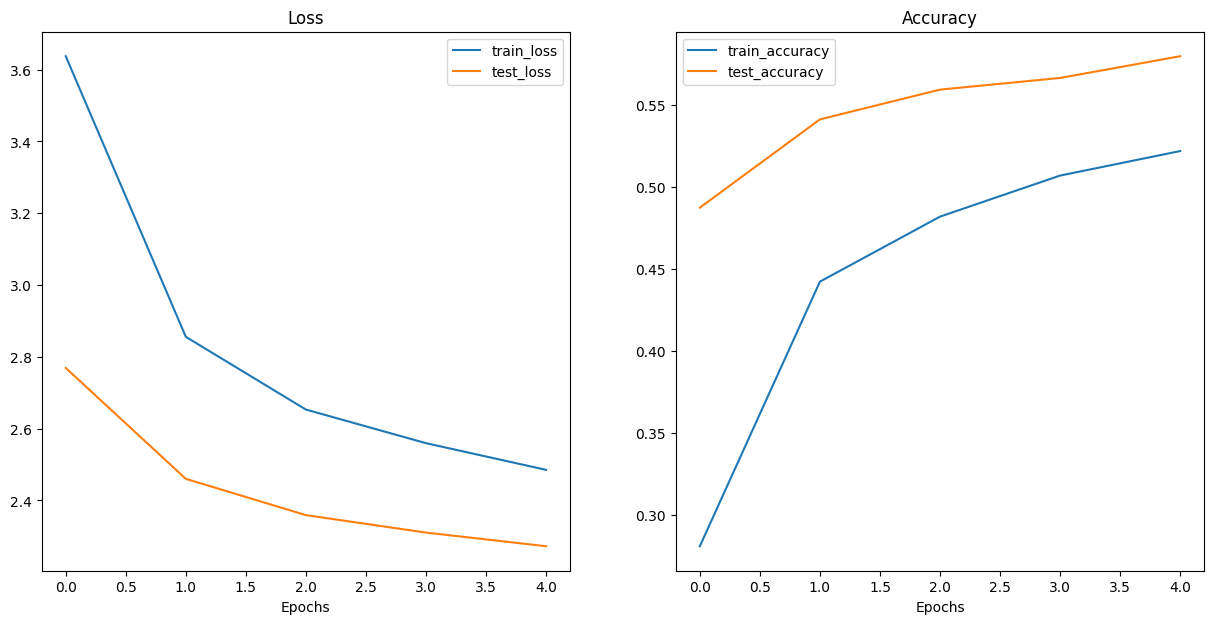

In [88]:
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_food101_results)

In [89]:
from going_modular import utils
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"
utils.save_model(
    model=effnetb2_food101,
    target_dir='models',
    model_name=effnetb2_food101_model_path
)

[INFO] Saving model to:  models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [90]:
loaded_effnetb2_food101, effnetb2_transforms \
    = create_effnetb2_model(num_classes=101)
loaded_effnetb2_food101.load_state_dict(torch.load(
    'models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth'
))

<All keys matched successfully>

In [91]:
from pathlib import Path
pretrained_effnetb2_food101_model_size = Path(
    'models', effnetb2_food101_model_path
).stat().st_size // (1024**2)
print(pretrained_effnetb2_food101_model_size, 'MB')

30 MB


In [92]:
from pathlib import Path

foodvision_big_demo_path = Path('demos/foodvision_big/')
foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)
(foodvision_big_demo_path / 'examples').mkdir(parents=True, exist_ok=True)

In [93]:
# Download and move an example image
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg 
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpg

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big

--2022-12-26 17:04:37--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg.1’

04-pizza-dad.jpeg.1 100%[===================>]   2.74M  8.46MB/s    in 0.3s    

2022-12-26 17:04:37 (8.46 MB/s) - ‘04-pizza-dad.jpeg.1’ saved [2874848/2874848]



In [94]:
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [95]:
foodvision_big_class_names_path = foodvision_big_demo_path / 'class_names.txt'

with open(foodvision_big_class_names_path, 'w') as f:
    print('[INFO] Saving Food101 class names to', foodvision_big_class_names_path)
    f.write('\n'.join(food101_class_names))

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [96]:
with open(foodvision_big_class_names_path, 'r') as f:
    food101_class_names_loaded = [food.strip() for food in f.readlines()]
food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [98]:
%%writefile demos/foodvision_big/model.py
import torch, torchvision
from torch import nn

def create_effnetb2_model(
    num_classes: int = 3,
    seed: int = 42
):
    """
    Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.
    
    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 images transforms.
    """
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False
    
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )

    return model, transforms

Writing demos/foodvision_big/model.py


In [99]:
%%writefile demos/foodvision_big/app.py
import gradio as gr
import os, torch
from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

with open('class_names.txt', 'r') as f:
    class_names = [food_name.strip() for food_name in f.readlines()]

effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=101)
effnetb2.load_state_dict(torch.load(
    f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
    map_location=torch.device('cpu')
))

def predict(img) -> Tuple[Dict, float]:
    """
    Transforms and performs a prediction on img and returns
    prediction and time taken.
    """
    start_time = timer()
    img = effnetb2_transforms(img).unsqueeze(0)

    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    pred_labels_and_probs = {
        class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))
    }
    pred_time = round(timer()-start_time, 5)
    return pred_labels_and_probs, pred_time

title = "FoodVision Big 🍔👁"
description = 'An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt).'
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

example_list = [['examples/' + example] for example in os.listdir('examples')]

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type='pil'),
    outputs=[
        gr.Label(num_top_classes=5, label='Predictions'),
        gr.Number(label='Prediction time (s)')
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article
)

demo.launch()

Writing demos/foodvision_big/app.py


In [100]:
%%writefile demos/foodvision_big/requirements.txt
torch>=1.12.0
torchvision>=0.13.0
gradio>=3.1.4

Writing demos/foodvision_big/requirements.txt


In [101]:
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"


  adding: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: app.py (deflated 50%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpg (deflated 0%)
  adding: model.py (deflated 54%)
  adding: requirements.txt (deflated 4%)
